Epoch 1/10
981/981 [==============================] - 46s 45ms/step - loss: 1.1141 - accuracy: 0.7029 - val_loss: 0.2722 - val_accuracy: 0.9269
Epoch 2/10
981/981 [==============================] - 65s 66ms/step - loss: 0.1820 - accuracy: 0.9539 - val_loss: 0.1253 - val_accuracy: 0.9653
Epoch 3/10
981/981 [==============================] - 45s 46ms/step - loss: 0.0988 - accuracy: 0.9766 - val_loss: 0.0786 - val_accuracy: 0.9783
Epoch 4/10
981/981 [==============================] - 40s 40ms/step - loss: 0.0665 - accuracy: 0.9820 - val_loss: 0.0722 - val_accuracy: 0.9821
Epoch 5/10
981/981 [==============================] - 40s 41ms/step - loss: 0.0494 - accuracy: 0.9869 - val_loss: 0.0599 - val_accuracy: 0.9842
Epoch 6/10
981/981 [==============================] - 40s 40ms/step - loss: 0.0398 - accuracy: 0.9894 - val_loss: 0.0554 - val_accuracy: 0.9832
Epoch 7/10
981/981 [==============================] - 40s 41ms/step - loss: 0.0283 - accuracy: 0.9923 - val_loss: 0.0672 - val_accuracy:

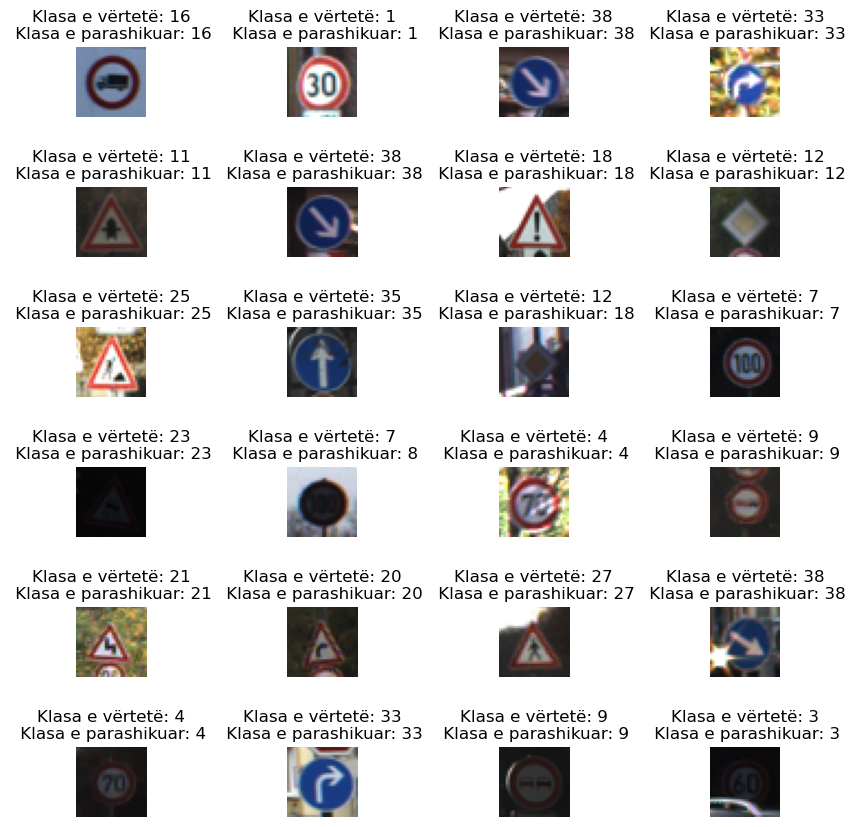

Matrica e konfuzionit:
[[ 41   1   0 ...   0   0   0]
 [  1 699  10 ...   0   0   0]
 [  0   4 723 ...   0   0   0]
 ...
 [  0   0   0 ...  89   0   0]
 [  0   0   0 ...   0  46   0]
 [  0   0   0 ...   0   0  90]]


In [2]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow import keras
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Përcaktimi i shtegut të datasetit
dataset_path = 'gtsrb-dataset'

# Ngarkimi i skedarëve CSV
train_data = pd.read_csv(os.path.join(dataset_path, 'Train.csv'))
test_data = pd.read_csv(os.path.join(dataset_path, 'Test.csv'))
meta_data = pd.read_csv(os.path.join(dataset_path, 'Meta.csv'))

# Ngarkimi dhe paraprocesimi i një imazhi të vetëm
def preprocess_image(image_path, class_id):
    image = Image.open(image_path)
    image = image.resize((32, 32))
    image_array = np.array(image)
    image_array = image_array / 255.0  # Normalizo imazhin
    return image_array, class_id

# Ngarkimi dhe paraprocesimi i imazheve të trajnimit
train_images = []
train_labels = []
for i, row in train_data.iterrows():
    image_path = os.path.join(dataset_path, row['Path'])
    image, class_id = preprocess_image(image_path, row['ClassId'])
    train_images.append(image)
    train_labels.append(class_id)

train_images = np.array(train_images)
train_labels = np.array(train_labels)

# Kryerja e kodimit one-hot në etiketat e trajnimit
label_binarizer = LabelBinarizer()
train_labels = label_binarizer.fit_transform(train_labels)

# Ndarja e të dhënave të trajnimit në pjesën e trajnimit dhe validimit
train_images, valid_images, train_labels, valid_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=123)

# Ngarkimi dhe paraprocesimi i imazheve të testimit
test_images = []
test_labels = []
for i, row in test_data.iterrows():
    image_path = os.path.join(dataset_path, row['Path'])
    image, class_id = preprocess_image(image_path, row['ClassId'])
    test_images.append(image)
    test_labels.append(class_id)

test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Krijimi i modelit të rrjetit konvolucional
model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(43, activation='softmax')
])

# Kompilimi i modelit
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Trajnimi i modelit
model.fit(train_images, train_labels, epochs=10, batch_size=32, validation_data=(valid_images, valid_labels))

# Konvertimi i etiketave të testimit në formatin one-hot
test_labels = label_binarizer.transform(test_labels)

# Vlerësimi i modelit në setin e testimit
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f'Gabimi i testimit: {test_loss:.4f}')
print(f'Saktësia e testimit: {test_accuracy:.4f}')

# Parashikimet mbi imazhet e testimit
predictions = model.predict(test_images)

# Konvertimi i parashikimeve në etiketa të klasave
predicted_labels = np.argmax(predictions, axis=1)

# Konvertimi i etiketave të testimit të koduara me one-hot në etiketat e tyre origjinale të klasave
true_labels = np.argmax(test_labels, axis=1)

# Shfaqja e imazheve të testimit të klasifikuara
fig, axes = plt.subplots(6, 4, figsize=(10, 10))
axes = axes.ravel()

for i in range(24):
    axes[i].imshow(test_images[i])
    axes[i].set_title(f"Klasa e vërtetë: {true_labels[i]}\n Klasa e parashikuar: {predicted_labels[i]}")
    axes[i].axis('off')

plt.subplots_adjust(hspace=1, wspace=0.5)  # Shtimi i hapësirës vertikale (hspace) dhe rregullimi i hapësirës horizontale (wspace)
plt.show()

# Llogaritja e matricës së konfuzionit
cm = confusion_matrix(np.argmax(test_labels, axis=1), predicted_labels)

print("Matrica e konfuzionit:")
print(cm)
